In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn

import matplotlib.pyplot as plt
import numpy as np

from nn_functions import init_network_params, pack_params, layer_sizes
from nn_functions import update_rmsprop, update_sgd, update_adam
from nn_functions import get_batches, loss, batched_predict
from nn_functions import top_eigenvalue
from complex_nn import train_nn

In [3]:
results = train_nn(
    update_method='adam',
    regularization=None,
    num_epochs=100,
    step_size=0.001,
    batch_size=16,
    use_adaptive_step_size=False,
    optimizer_params={'beta1': 0.99, 'beta2': 0.999, 'epsilon': 1e-8},
)

Epoch 0 — Loss: 6.8928e-02  |  ‖grad‖: 1.3837e+00  |  λ_max(H): 7.1947e+01
Epoch 1 — Loss: 6.3481e-02  |  ‖grad‖: 1.1107e+00  |  λ_max(H): 7.1318e+01
Epoch 2 — Loss: 4.4730e-02  |  ‖grad‖: 1.0030e+00  |  λ_max(H): 7.4331e+01
Epoch 3 — Loss: 4.4456e-02  |  ‖grad‖: 9.5890e-01  |  λ_max(H): 7.2204e+01
Epoch 4 — Loss: 4.7741e-02  |  ‖grad‖: 9.8399e-01  |  λ_max(H): 7.7179e+01
Epoch 5 — Loss: 3.7351e-02  |  ‖grad‖: 9.3053e-01  |  λ_max(H): 7.2899e+01
Epoch 6 — Loss: 4.1797e-02  |  ‖grad‖: 8.7392e-01  |  λ_max(H): 7.3625e+01
Epoch 7 — Loss: 3.6690e-02  |  ‖grad‖: 8.9980e-01  |  λ_max(H): 7.2352e+01
Epoch 8 — Loss: 3.3786e-02  |  ‖grad‖: 8.6002e-01  |  λ_max(H): 7.1511e+01
Epoch 9 — Loss: 3.0716e-02  |  ‖grad‖: 8.2988e-01  |  λ_max(H): 7.3437e+01
Epoch 10 — Loss: 2.9355e-02  |  ‖grad‖: 8.2410e-01  |  λ_max(H): 7.2157e+01
Epoch 11 — Loss: 3.1992e-02  |  ‖grad‖: 7.8963e-01  |  λ_max(H): 7.2118e+01
Epoch 12 — Loss: 2.9708e-02  |  ‖grad‖: 8.0691e-01  |  λ_max(H): 7.2155e+01
Epoch 13 — Loss: 3.588

In [4]:
4417 * (77000/32) * 10

106284062.5

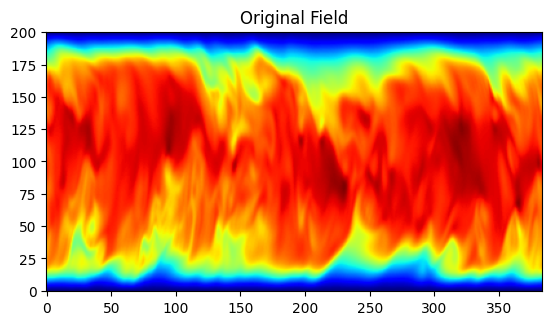

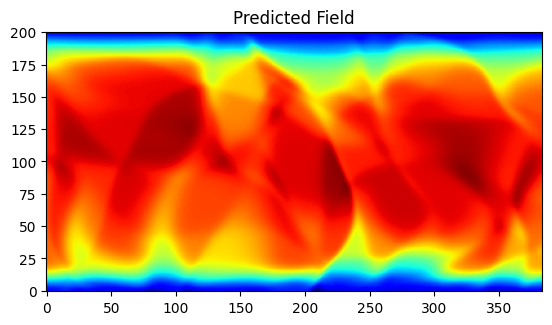

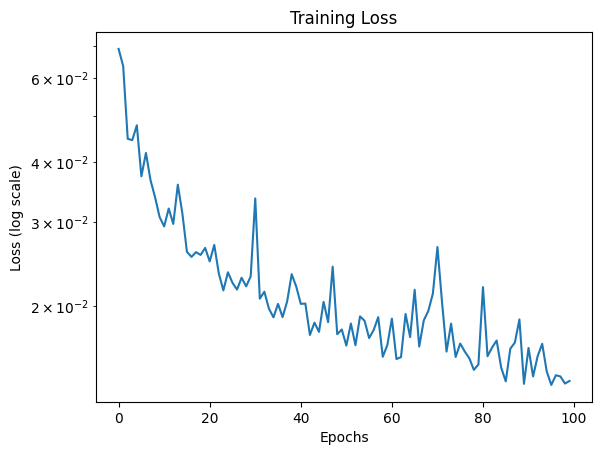

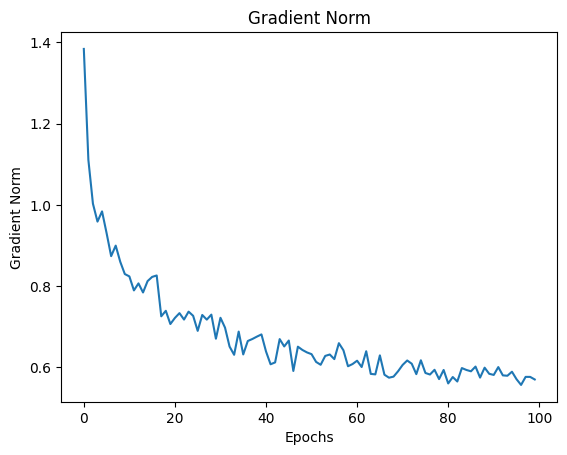

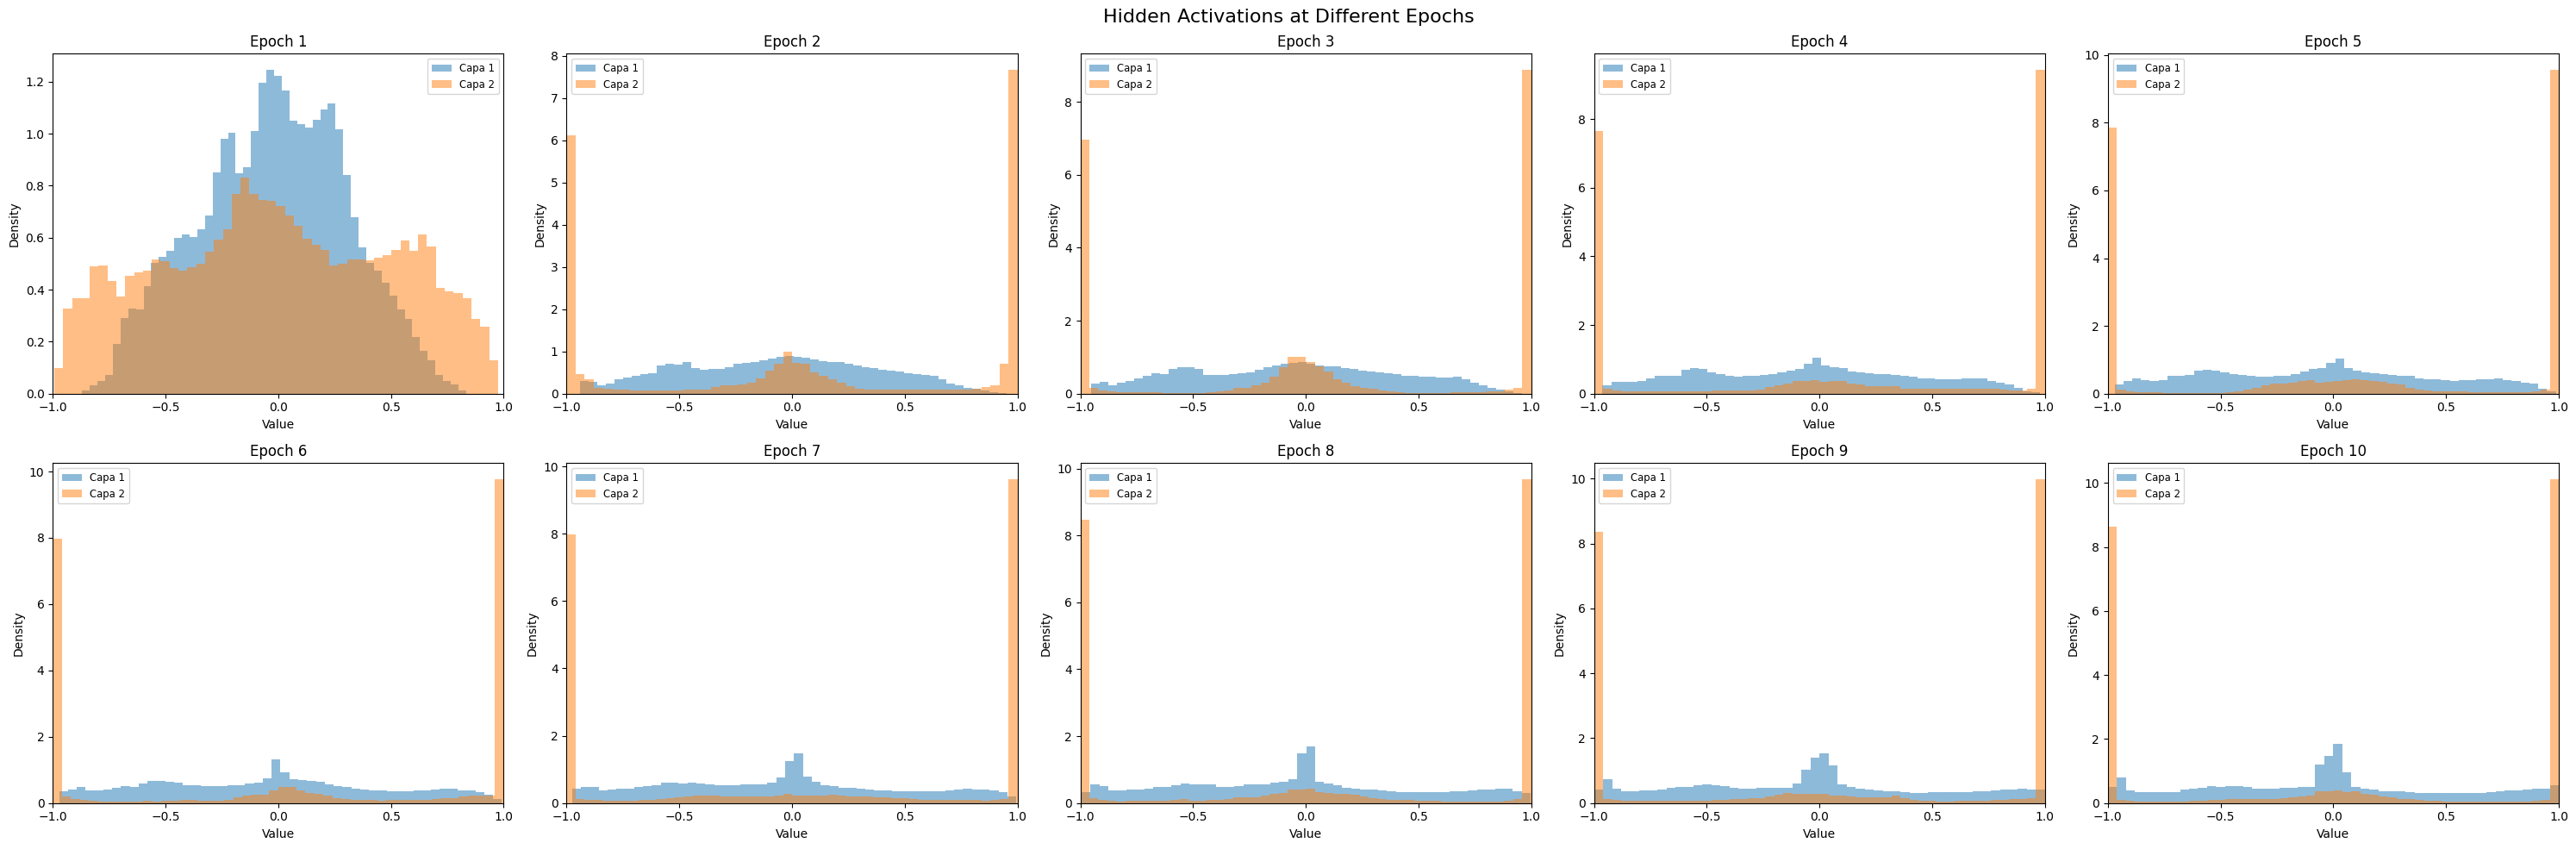

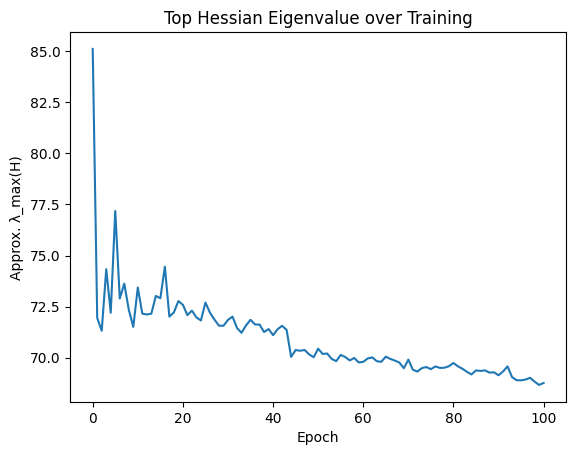

In [5]:
# Load data
field = jnp.load('field.npy')
field = field - field.mean()
field = field / field.std()
field = jnp.array(field, dtype=jnp.float32)
nx, ny = field.shape
xx = jnp.linspace(-1, 1, nx)
yy = jnp.linspace(-1, 1, ny)
xx, yy = jnp.meshgrid(xx, yy, indexing='ij')
xx = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
ff = field.reshape(-1, 1)

# Plot results
plt.figure()
plt.title('Original Field')
plt.imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')

plt.figure()
plt.title('Predicted Field')
plt.imshow(batched_predict(results['params'], xx)[0].reshape((nx, ny)).T, origin='lower', cmap='jet')

# Plot loss function
plt.figure()
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.semilogy(results['log_train'])

# Plot gradient norm
plt.figure()
plt.title('Gradient Norm')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.plot(results['grads_norm'])

# Especifica los epochs que quieres plotear
# epochs_to_plot = [0, 5, 10]
epochs_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, axes = plt.subplots(2, 5, figsize=(30, 10), squeeze=False)
for ax, epoch in zip(axes.flatten(), epochs_to_plot):
    hidden_activations = results['all_hidden_activations'][epoch]
    flat0 = hidden_activations[0].ravel()
    flat1 = hidden_activations[1].ravel()
    ax.hist(flat0, bins=50, alpha=0.5, density=True, label='Capa 1')
    ax.hist(flat1, bins=50, alpha=0.5, density=True, label='Capa 2')
    ax.set_title(f'Epoch {epoch+1}')
    ax.set_xlim(-1, 1)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize='small')

plt.suptitle('Hidden Activations at Different Epochs', fontsize=16)
plt.tight_layout()

# --- plot how λ_max evolves ---
plt.figure()
plt.plot(results['hess_max'])
plt.xlabel("Epoch")
plt.ylabel("Approx. λ_max(H)")
plt.title("Top Hessian Eigenvalue over Training")

# Show all plots
plt.show()

/var/folders/_r/157z0l_91ps9f7pvx9d8nf0c0000gn/T/ipykernel_24070/3949304302.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


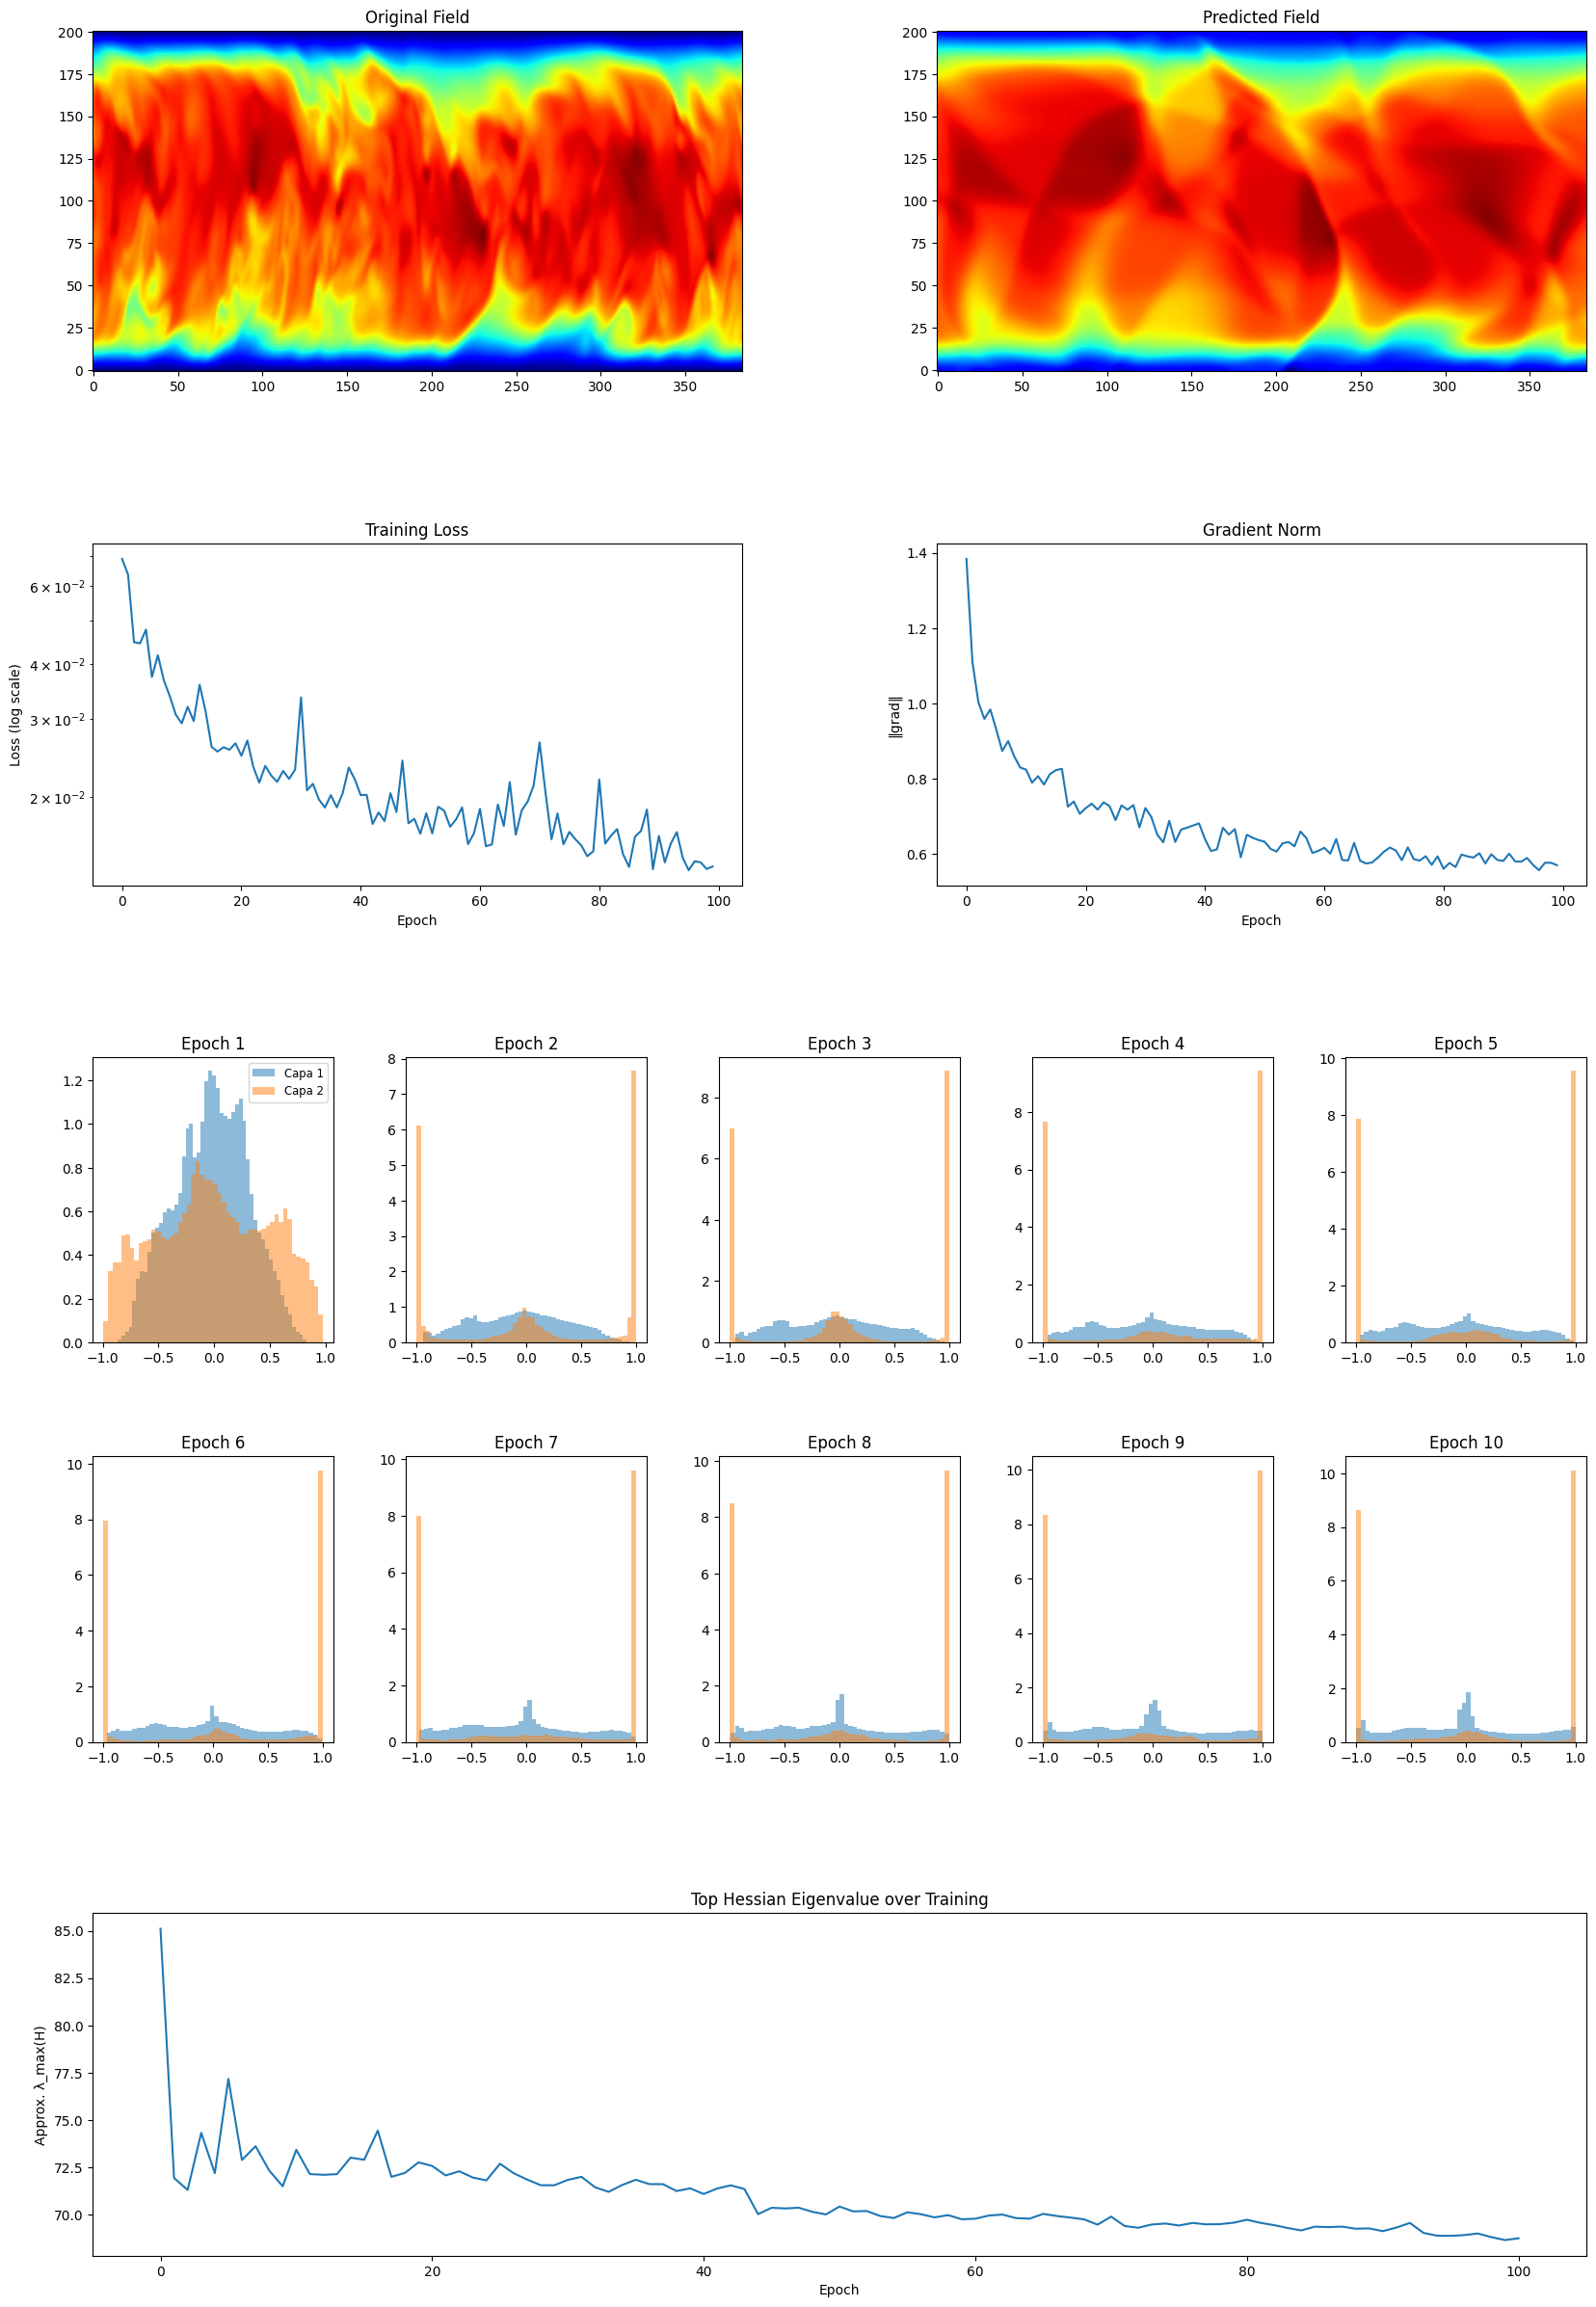

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# assume xx, ff, nx, ny, results, epochs_to_plot are already defined

fig = plt.figure(figsize=(20, 30))
outer = GridSpec(4, 1, height_ratios=[1, 1, 2, 1], hspace=0.4)

# ── Row 0: original & predicted fields ─────────────────────────────
gs0 = outer[0].subgridspec(1, 2, wspace=0.3)
ax0 = fig.add_subplot(gs0[0, 0])
ax1 = fig.add_subplot(gs0[0, 1])

ax0.set_title("Original Field")
ax0.imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')

ax1.set_title("Predicted Field")
pred = batched_predict(results['params'], xx)[0]
ax1.imshow(pred.reshape((nx, ny)).T, origin='lower', cmap='jet')


# ── Row 1: loss & gradient norm ────────────────────────────────────
gs1 = outer[1].subgridspec(1, 2, wspace=0.3)
ax2 = fig.add_subplot(gs1[0, 0])
ax3 = fig.add_subplot(gs1[0, 1])

ax2.set_title("Training Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss (log scale)")
ax2.semilogy(results['log_train'])

ax3.set_title("Gradient Norm")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("‖grad‖")
ax3.plot(results['grads_norm'])


# ── Row 2–3: hidden activations histograms ────────────────────────
gs2 = outer[2].subgridspec(2, 5, wspace=0.3, hspace=0.4)
epochs_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# epochs_to_plot = np.arange(0, 50, 5)  # Plot every 5 epochs
for idx, epoch in enumerate(epochs_to_plot):
    row, col = divmod(idx, 5)
    ax = fig.add_subplot(gs2[row, col])
    hidden_activations = results['all_hidden_activations'][epoch]
    flat0 = hidden_activations[0].ravel()
    flat1 = hidden_activations[1].ravel()
    ax.hist(flat0, bins=50, alpha=0.5, density=True, label='Capa 1')
    ax.hist(flat1, bins=50, alpha=0.5, density=True, label='Capa 2')
    ax.set_title(f"Epoch {epoch+1}")
    # ax.set_xlim(-1, 1)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    if row == 0 and col == 0:
        ax.legend(fontsize='small')


# ── Row 4: top Hessian eigenvalue ──────────────────────────────────
ax4 = fig.add_subplot(outer[3, 0])
ax4.set_title("Top Hessian Eigenvalue over Training")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Approx. λ_max(H)")
ax4.plot(results['hess_max'])

plt.tight_layout()
plt.show()